# [Chefkoch.de](http://www.chefkoch.de/) Maturaarbeit 2017/18
------

## Ziel: 
### Topic modeling:  Dimensionsreduzierung von Rezept Namen in n Kategorien (4.Teil)

## Natural Language Processing:
### Durchgeführte Methoden:
- [Latent Dirichlet Allocation (LDA)](https://de.wikipedia.org/wiki/Latent_Dirichlet_Allocation)
- [Hierarchical Dirichlet process (HDP)](https://en.wikipedia.org/wiki/Hierarchical_Dirichlet_process)
- [Non-negative Matrix Factorization](https://en.wikipedia.org/wiki/Non-negative_matrix_factorization)

## [Hoffman, Blei, Bach: Online Learning for Latent Dirichlet Allocation](https://www.di.ens.fr/~fbach/mdhnips2010.pdf)
## [Wang, Paisley, Blei: Online Variational Inference for the Hierarchical Dirichlet Process](http://proceedings.mlr.press/v15/wang11a/wang11a.pdf)
## [Da Kuang: Nonnegative matrix factorization for interactive topic modeling and document clustering](https://www.cc.gatech.edu/~hpark/papers/nmf_book_chapter.pdf)
## Python Implementation [1](https://radimrehurek.com/gensim/models/ldamodel.html) [2](https://github.com/bmabey/pyLDAvis)

In [1]:
import csv
import random
from operator import itemgetter

from stop_words import get_stop_words
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer

from sklearn.manifold import TSNE
from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

from gensim import corpora, models
import gensim

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib
%matplotlib inline

from pprint import pprint
import pyLDAvis.gensim as gensimvis
import pyLDAvis
pyLDAvis.enable_notebook()

In [2]:
def get_recipe_names():
    recipe_names = []
    skip_first = True # col name
    chef_file = 'input/test/chefkoch_rezepte_analysis.csv'
    with open(chef_file, 'r') as f:
        chefkoch = csv.reader(f)
        for row in chefkoch:
            if skip_first:
                skip_first = False
                continue
            try:
                recipe_names.append(row[2])
            except: 
                continue 
    return(recipe_names)

def get_recipe_years():
    recipe_years = []
    skip_first = True # col name
    chef_file = 'input/test/chefkoch_rezepte_analysis.csv'
    with open(chef_file, 'r') as f:
        chefkoch = csv.reader(f)
        for row in chefkoch:
            if skip_first:
                skip_first = False
                continue
            try:
                recipe_years.append(row[-2])
            except: 
                continue 
    return(recipe_years)

recipe_names = get_recipe_names()
print('Anzahl aller Rezeptnamen:', len(recipe_names)) # Anzahl aller Rezeptnamen

print('20 raw recipe names: \n >>>')
pprint(recipe_names[:20])

Anzahl aller Rezeptnamen: 316755
20 raw recipe names: 
 >>>
['Bratapfel-Rotkohl',
 '„Frühstückswolke 7“ aus Fiefhusen',
 'Deichgrafensalat von der Westküste',
 'Geschichteter Kohl',
 'Rinderlendenragout',
 'Blaukraut mit Butter-Maroni',
 'Sauerbraten à la Tick',
 'Punschtorte',
 'Gebackene Oberländer',
 'McMoes bunter Pasta-Topf "Allerlei"',
 'Geschnetzeltes mit gebratenen Radieschen',
 'Ahorn-Bacon-Butter',
 'Warmer Endiviensalat mit Mettwürstchen',
 'Rote-Linsen-Gemüse-Pfanne',
 'Kotelett-Gratin mit Pilzen und Schupfnudeln',
 'Rotkohl',
 'Remouladensauce aus Schmand',
 'Nudeln mit Cashewsauce und Tempeh "Meta-Typ Alpha"',
 'Kohlsuppe',
 'Gemüse-Hackfleischauflauf']


In [3]:
seen = set()
uniq = []
duplicates = []
for x in recipe_names:
    if x not in seen:
        uniq.append(x)
        seen.add(x)
    else: duplicates.append(x)

print('Anzahl einzigartiger Rezeptnamen:',len(uniq)) # Anzahl einzigartiger Rezeptnamen

duplicates.sort()

print('Anzahl Duplikate',len(duplicates))
print('20 dupliactes: \n >>>')
pprint(duplicates[:20])

Anzahl einzigartiger Rezeptnamen: 260907
Anzahl Duplikate 55848
20 dupliactes: 
 >>>
['24 - Stunden - Salat',
 '3 - Minuten - Brot',
 '3 - Tage - Torte',
 '3 - Tage - Torte',
 '43 Sunset',
 '5 - Minuten - Brot',
 '5 - Minuten - Kuchen',
 '5 - Minuten - Kuchen',
 '5 - Minuten - Tiramisu',
 '6 - Salat',
 '7 - Tassen - Salat',
 '7 - Tassen - Salat',
 '7 - Tassen - Salat',
 '7 Tassen - Salat',
 '7 Tassen Salat',
 'ACE-Marmelade',
 'Aachener Poschweck',
 'Aachener Printen',
 'Aachener Reisfladen',
 'Aalterrine']


# Säubern der Rezept Namen

## 1. Tokenisierung

Nur falls es nicht mit diesem Wort anfängt und der String nachher nicht leer ist

1. replace('und ...', 'mit nichts')
2. replace('à la ...', 'mit nichts')
3. replace('von ...', 'mit nichts')
4. replace('aus ...', 'mit nichts')
5. replace('mit ...', 'mit nichts')
6. replace('ohne ...', 'mit nichts')
7. replace('in ...', 'mit nichts')
8. replace('auf ...', 'mit nichts')
9. replace('für ...', 'mit nichts')
10. replace('nach ...', 'mit nichts')
11. replace('by ...', 'mit nichts')
12. replace('zu ...', 'mit nichts')
13. replace('"..."', 'mit nichts')
14. replace('-', 'space')

In [3]:
import re
# 1
first_iter = []
regex = re.compile(r" und.*", re.IGNORECASE)
for r_name in recipe_names:
    if r_name.lower().startswith('und '):
        first_iter.append(r_name)
        continue # skip
    new_name = regex.sub('', r_name)
    if len(new_name) is not 0: first_iter.append(new_name)
    else: first_iter.append(r_name)
print(len(first_iter))
# 2
sec_iter = []
regex = re.compile(r" à la.*", re.IGNORECASE)
for r_name in first_iter:
    if r_name.lower().startswith('à la '):
        sec_iter.append(r_name)
        continue # skip
    new_name = regex.sub('', r_name)
    if len(new_name) is not 0: sec_iter.append(new_name)
    else: sec_iter.append(r_name)
print(len(sec_iter))
# 3
third_iter = []
regex = re.compile(r" von.*", re.IGNORECASE)
for r_name in sec_iter:
    if r_name.lower().startswith('von '):
        third_iter.append(r_name) # skip
        continue
    new_name = regex.sub('', r_name)
    if len(new_name) is not 0: third_iter.append(new_name)
    else: third_iter.append(r_name)
print(len(third_iter))
# 4
fourth_iter = []
regex = re.compile(r" aus.*", re.IGNORECASE)
for r_name in third_iter:
    if r_name.lower().startswith('aus '):
        fourth_iter.append(r_name) # skip
        continue
    new_name = regex.sub('', r_name)
    if len(new_name) is not 0: fourth_iter.append(new_name)
    else: fourth_iter.append(r_name)
print(len(fourth_iter))
# 5
fifth_iter = []
regex = re.compile(r" mit.*", re.IGNORECASE)
for r_name in fourth_iter:
    if r_name.lower().startswith('mit '):
        fifth_iter.append(r_name) # skip
        continue
    new_name = regex.sub('', r_name)
    if len(new_name) is not 0: fifth_iter.append(new_name)
    else: fifth_iter.append(r_name)
print(len(fifth_iter))
# 6
sixth_iter = []
regex = re.compile(r" ohne.*", re.IGNORECASE)
for r_name in fifth_iter:
    if r_name.lower().startswith('ohne '):
        sixth_iter.append(r_name) # skip
        continue
    new_name = regex.sub('', r_name)
    if len(new_name) is not 0: sixth_iter.append(new_name)
    else: sixth_iter.append(r_name)
print(len(sixth_iter))
# 7
seventh_iter = []
regex = re.compile(r" in.*", re.IGNORECASE)
for r_name in sixth_iter:
    if r_name.lower().startswith('in '):
        seventh_iter.append(r_name) # skip
        continue
    new_name = regex.sub('', r_name)
    if len(new_name) is not 0: seventh_iter.append(new_name)
    else: seventh_iter.append(r_name)
print(len(seventh_iter))
# 8
eigth_iter = []
regex = re.compile(r" auf.*", re.IGNORECASE)
for r_name in seventh_iter:
    if r_name.lower().startswith('auf '):
        eigth_iter.append(r_name) # skip
        continue
    new_name = regex.sub('', r_name)
    if len(new_name) is not 0: eigth_iter.append(new_name)
    else: eigth_iter.append(r_name)
print(len(eigth_iter))
# 9
ninth_iter = []
regex = re.compile(r" für.*", re.IGNORECASE)
for r_name in eigth_iter:
    if r_name.lower().startswith('für '):
        ninth_iter.append(r_name) # skip
        continue
    new_name = regex.sub('', r_name)
    if len(new_name) is not 0: ninth_iter.append(new_name)
    else: ninth_iter.append(r_name)
print(len(ninth_iter))
# 10
tenth_iter = []
regex = re.compile(r" nach.*", re.IGNORECASE)
for r_name in ninth_iter:
    if r_name.lower().startswith('nach '):
        tenth_iter.append(r_name)# skip
        continue
    new_name = regex.sub('', r_name)
    if len(new_name) is not 0: tenth_iter.append(new_name)
    else: tenth_iter.append(r_name)
print(len(tenth_iter))
# 11
eleventh_iter = []
regex = re.compile(r" by.*", re.IGNORECASE)
for r_name in tenth_iter:
    if r_name.lower().startswith('by '): continue # skip
    new_name = regex.sub('', r_name)
    if len(new_name) is not 0: eleventh_iter.append(new_name)
    else: eleventh_iter.append(r_name)
print(len(eleventh_iter))
# 12
twelveth_iter = []
regex = re.compile(r" zu.*", re.IGNORECASE)
for r_name in eleventh_iter:
    if r_name.lower().startswith('zu '):
        twelveth_iter.append(r_name)# skip
        continue
    new_name = regex.sub('', r_name)
    if len(new_name) is not 0: twelveth_iter.append(new_name)
    else: twelveth_iter.append(r_name)
print(len(twelveth_iter))
# 13
thirteenth_iter = []
regex = re.compile(r'".*?"', re.IGNORECASE)
for r_name in twelveth_iter:
    #if r_name.lower().startswith('zu '): continue # skip
    new_name = regex.sub('', r_name)
    if len(new_name)>1: thirteenth_iter.append(new_name)
    else: thirteenth_iter.append(r_name)
print(len(thirteenth_iter))
# remove leading and ending spaces
fourteenth_iter = []
for r_name in thirteenth_iter:
    new_name = r_name.strip()
    fourteenth_iter.append(new_name)
print(len(fourteenth_iter))
# remove all quotes
fiftheen_iter = []
for r_name in fourteenth_iter:
    new_name = r_name.replace('"', '')
    fiftheen_iter.append(new_name)
print(len(fiftheen_iter))
# 16
sixteenth_iter = []
regex = re.compile(r"'.*?'", re.IGNORECASE)
for r_name in fiftheen_iter:
    #if r_name.lower().startswith('zu '): continue # skip
    new_name = regex.sub('', r_name)
    if len(new_name)>1: sixteenth_iter.append(new_name)
    else: sixteenth_iter.append(r_name)
print(len(sixteenth_iter))
# remove again leading and ending spaces
seventeenth_iter = []
for r_name in sixteenth_iter:
    new_name = r_name.strip()
    seventeenth_iter.append(new_name)
print(len(seventeenth_iter))
# remove all quotes '
eigththeen_iter = []
for r_name in seventeenth_iter:
    new_name = r_name.replace("'", "")
    eigththeen_iter.append(new_name)
print(len(eigththeen_iter))
# 19 remove (...)
nineteenth_iter = []
regex = re.compile(r"\(.*?\)", re.IGNORECASE)
for r_name in eigththeen_iter:
    #if r_name.lower().startswith('zu '): continue # skip
    new_name = regex.sub('', r_name)
    if len(new_name)>2: nineteenth_iter.append(new_name)
    else: nineteenth_iter.append(r_name)
print(len(nineteenth_iter))
# remove -
twenteenth_iter = []
for r_name in nineteenth_iter:
    if r_name.startswith('- '):
        new_name = r_name.replace("- ", "")
        twenteenth_iter.append(new_name)
    elif r_name.startswith('-'):
        new_name = r_name.replace("-", "")
        twenteenth_iter.append(new_name)
    else: twenteenth_iter.append(r_name)
print(len(twenteenth_iter))
# remove again leading and ending spaces
twentyoneth_iter = []
for r_name in twenteenth_iter:
    new_name = r_name.strip()
    twentyoneth_iter.append(new_name)
print(len(twentyoneth_iter))
# add space around -
twentytwoth_iter = []
for r_name in twentyoneth_iter:
    new_name = r_name.replace("-", " - ")
    twentytwoth_iter.append(new_name)
print(len(twentytwoth_iter))
# 23 remove all numbers
twentytird_iter = []
regex = re.compile(r'[0-9].*?(?=\s)', re.IGNORECASE)
for r_name in twentytwoth_iter:
    #if r_name.lower().startswith('zu '): continue # skip
    new_name = regex.sub('', r_name)
    twentytird_iter.append(new_name)
print(len(twentytird_iter))
# 24 remove everything but letters
twentyfourth_iter = []
regex = re.compile(r'[^A-Za-zäöüßéàèêëïùâîûç]+', re.IGNORECASE)
for r_name in twentytird_iter:
    new_name = regex.sub(' ', r_name)
    twentyfourth_iter.append(new_name)
print(len(twentyfourth_iter))
# remove again leading and ending spaces
twentyfifth_iter = []
for r_name in twentyfourth_iter:
    new_name = r_name.strip()
    twentyfifth_iter.append(new_name)
print(len(twentyfifth_iter))
# 26 remove all single letters
twentysixth_iter = []
regex = re.compile(r'(?:^| )\w(?:$| )', re.IGNORECASE)
for r_name in twentyfifth_iter:
    new_name = regex.sub(' ', r_name).strip()
    twentysixth_iter.append(new_name)
print(len(twentysixth_iter))
# 27 remove empty entries
twentyseventh_iter = []
for r_name in twentysixth_iter:
    if len(r_name) < 1: twentyseventh_iter.append('error') # just skip
    else: twentyseventh_iter.append(r_name)
print(len(twentyseventh_iter))
# 28
twentyeigth_iter = []
regex = re.compile(r" im.*", re.IGNORECASE)
for r_name in twentyseventh_iter:
    if r_name.lower().startswith('im '):
        twentyeigth_iter.append(r_name) # skip
        continue
    new_name = regex.sub('', r_name)
    if len(new_name) is not 0: twentyeigth_iter.append(new_name)
    else: twentyeigth_iter.append(r_name)
print(len(sixth_iter))

316755
316755
316755
316755
316755
316755
316755
316755
316755
316755
316755
316755
316755
316755
316755
316755
316755
316755
316755
316755
316755
316755
316755
316755
316755
316755
316755
316755


## Nach 28 handgefertigten Bedingungen sieht das ganze so aus:

In [37]:
print('Nach 28 handgefertigten Bedingungen sieht das ganze so aus: \n >>>')
pprint(random.sample(twentyeigth_iter, len(twentyeigth_iter))[:50])

Nach 28 handgefertigten Bedingungen sieht das ganze so aus: 
 >>>
['Pizzabrot',
 'Feigensalat',
 'Paprika',
 'Gefüllter Tannenbaum',
 'Grüne Bohnen',
 'Spitzbuben',
 'Omis Philadelphiatorte',
 'Zwetschgenkuchen',
 'Chrissis Kräutersauce',
 'Mohn Nuss Roulade',
 'Eintopf',
 'Indischer Reissalat',
 'Hackcurry',
 'Einfacher Bierteig',
 'Artischockenherzen',
 'Geschnetzeltes',
 'Gefüllte Hackfleischnester',
 'Weihnachts Zwieback',
 'Heidesand Schoko Chili',
 'Vegetarische Bolognese',
 'Wirsingsuppe',
 'Kartoffelsalat',
 'Katrins Kaffeemuffins',
 'Kartoffelcurry',
 'Schnelles Sonnenblumenkernbrot',
 'Konditorcreme',
 'Pasta mediterrano Italiano',
 'Doppelt gespicktes Kingklipfilet',
 'Eierlikörkuchen',
 'Chinesische Suppe pikant',
 'Schoko Bananen Kuchen',
 'Kaffeekuchen saftiger',
 'Kartoffel Birnen',
 'Schlesischer Hochzeitskuchen',
 'Nicoles Nudelpfanne',
 'Schokoladen Rührkuchen',
 'Holunderlikör',
 'Schokolade Kaffee Kranz',
 'Vier Beeren Gelee',
 'Omelett',
 'Herbstlicher Salat',
 'Ki

## 2. Stoppwörter entfernen und Stammformreduktion

Unwichtige Wörter wie *welche*, *sich*, *manches*, *einige* etc. entfernen und Wörter auf ihren Wortstamm reduzieren.

In [4]:
de_stop = get_stop_words('german')
s_stemmer = SnowballStemmer('german')
tokenizer = RegexpTokenizer(r'\w+')
final_names = []
filter_words_ = ['low carb',
               'vegane', 
               'smokeys',
               'schnelle',
               'schneller',
               'single',
               'veganer',
               'überbackene',
               'bunter',
               'gebratene',
               'grüner',
               'grünes', 
               'vegetarische',
               'italienisch',
               'scharfe',
               'krümeltigers',
               'pfanne',
               'mini',
               'warmer',
               'gefüllt',
               'gefüllte',
               'pikante',
               'schnelles',
               'rezept',
               'dessert',
               'bunte',
               'gebackene',
               'feierabend',
               'omas',
               'topf',
               'mediterrane',
               'mal',
               'saftig',
               'mediterraner',
               'saftiger',
               'saftiges',
                 'nr',
                 'abendessen',
                 'achims']

for recipe_name in twentyeigth_iter:
    raw = recipe_name.lower()
    tokens = tokenizer.tokenize(raw)
    stop_t = [recipe_name for recipe_name in tokens if not recipe_name in de_stop and not recipe_name in filter_words_]
    stem_t = [i for i in stop_t if len(i)>1]
    if len(stem_t)==0: final_names.append(['error'])
    else: final_names.append(stem_t)

print('Fertig gesäuberte Rezeptnamen: \n >>>')
pprint(final_names[:20])

Fertig gesäuberte Rezeptnamen: 
 >>>
[['bratapfel', 'rotkohl'],
 ['frühstückswolke'],
 ['deichgrafensalat'],
 ['geschichteter', 'kohl'],
 ['rinderlendenragout'],
 ['blaukraut'],
 ['sauerbraten'],
 ['punschtorte'],
 ['oberländer'],
 ['mcmoes', 'pasta'],
 ['geschnetzeltes'],
 ['ahorn', 'bacon', 'butter'],
 ['endiviensalat'],
 ['rote', 'linsen', 'gemüse'],
 ['kotelett', 'gratin'],
 ['rotkohl'],
 ['remouladensauce'],
 ['nudeln'],
 ['kohlsuppe'],
 ['gemüse', 'hackfleischauflauf']]


In [5]:
print(len(final_names))
print(len(twentyeigth_iter))

316755
316755


In [6]:
sorted(final_names)[:20]

[['aachener', 'feuerzangenbowle'],
 ['aachener', 'poschweck'],
 ['aachener', 'poschweck'],
 ['aachener', 'printen'],
 ['aachener', 'printen'],
 ['aachener', 'printen'],
 ['aachener', 'printen', 'ii'],
 ['aachener', 'printen', 'iii'],
 ['aachener', 'printen', 'schichtspeise'],
 ['aachener', 'printenauflauf'],
 ['aachener', 'reisfladen'],
 ['aachener', 'reisfladen'],
 ['aachener', 'suppe'],
 ['aal'],
 ['aal'],
 ['aal'],
 ['aal'],
 ['aal'],
 ['aal'],
 ['aal']]

# Topic Modeling

## Versuch 1: Latent Dirichlet Allocation (LDA) mit 250 Topics

In [9]:
dictionary = corpora.Dictionary(final_names)
# save dictionary
#dictionary.save('input/test/topic_modeling_dictionary_2.dict')
corpus = [dictionary.doc2bow(text) for text in final_names]
# save corpus
#corpora.MmCorpus.serialize('input/test/corpus_2_lda.mm', corpus)

In [10]:
print(dictionary)

Dictionary(61052 unique tokens: ['bratapfel', 'rotkohl', 'frühstückswolke', 'deichgrafensalat', 'geschichteter']...)


In [ ]:
%%time
# generate LDA model
ldamodel = models.ldamodel.LdaModel(corpus, num_topics=250, id2word = dictionary, passes=15)
ldamodel.save('input/test/kategorien_250_61052_lda.model')

In [11]:
ldamodel = models.ldamodel.LdaModel.load('input/test/kategorien_250_61052_lda.model')

In [13]:
ldamodel.print_topics()[:10]

[(178,
  '0.313*"gulasch" + 0.208*"gegrillte" + 0.200*"pilz" + 0.170*"karotten" + 0.000*"schwammaschnitz" + 0.000*"salzzitronenhuhn" + 0.000*"tresterfleisch" + 0.000*"dellarmonia" + 0.000*"sauerkrautrollen" + 0.000*"weihnachtscantucci"'),
 (150,
  '0.492*"warmer" + 0.060*"endiviensalat" + 0.000*"schwammaschnitz" + 0.000*"tannenzapfen" + 0.000*"dellarmonia" + 0.000*"sauerkrautrollen" + 0.000*"mohnkringel" + 0.000*"rabbsub" + 0.000*"schichtbecher" + 0.000*"spitzkohlsüppchen"'),
 (30,
  '0.807*"spaghetti" + 0.128*"süße" + 0.000*"mohnkringel" + 0.000*"tresterfleisch" + 0.000*"dellarmonia" + 0.000*"sauerkrautrollen" + 0.000*"rabbsub" + 0.000*"schwammaschnitz" + 0.000*"megaschokoladige" + 0.000*"salzzitronenhuhn"'),
 (161,
  '0.503*"entenbrust" + 0.091*"kokosnuss" + 0.088*"apfelauflauf" + 0.021*"stuten" + 0.009*"gebeizt" + 0.000*"nuoc" + 0.000*"tresterfleisch" + 0.000*"dellarmonia" + 0.000*"sauerkrautrollen" + 0.000*"rabbsub"'),
 (65,
  '0.405*"weiße" + 0.166*"burger" + 0.106*"karamellisiert

## Visualisieren des LDA Model mit [pyLDAvis](https://github.com/bmabey/pyLDAvis)

In [14]:
vis_data = gensimvis.prepare(ldamodel, corpus, dictionary)

## Interaktive Graphik

In [15]:
pyLDAvis.display(vis_data)

### Das Model ist sich z.B. im 73 Topic sicher, dass Mango und Orange in die gleiche Kategorie gehören sollten. Oder gute Ergebnisse zeigt auch Topic 89: Cocktail,  Colada, Tee, Pina, Summer, und Virgin sollten in die gleiche Kategorie gehören laut dem Model. Komischerweise empfiehlt es auch Kinderkuchen in diese Kategorie.

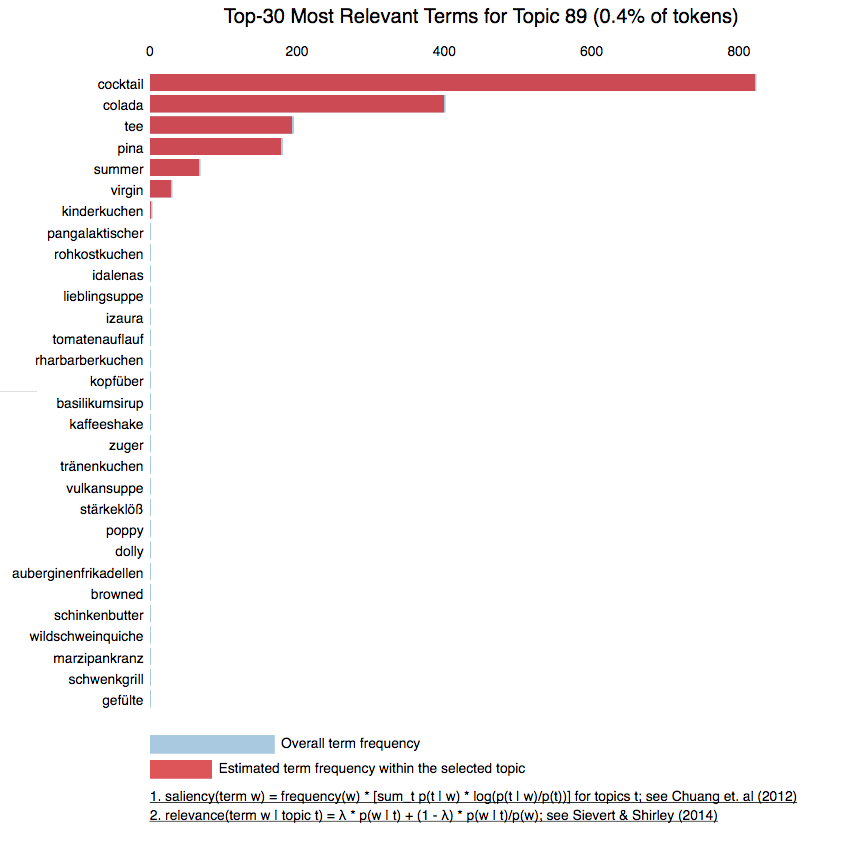

In [3]:
from IPython.display import Image
PATH = "/Users/Muriz/Desktop/"
Image(filename = PATH + "topic.png", width='60%', height=140)

Mit einem kurzen Skript können zusammenhängende Rezepte zu einem Begriff ausgegeben werden.

In [16]:
def get_related_recipes(term, top):
    print(">>>>>",top," top recipes related to ",term,"<<<<<<")
    related_docid = []
    doc_topics = ldamodel.get_document_topics(corpus, minimum_probability=0.10)
    term_topics =  ldamodel.get_term_topics(term, minimum_probability=0.000001)
    for k,topics in enumerate(doc_topics):
        if topics:
            topics.sort(key = itemgetter(1), reverse=True)
            if topics[0][0] == term_topics[0][0]:
                related_docid.append((k,topics[0][1]))
    
    related_docid.sort(key = itemgetter(1), reverse=True)
    for j,doc_id in enumerate(related_docid):
        print(final_names[doc_id[0]],"\n",doc_id[1],"\n")
        if j == (top-1):
            break

In [18]:
get_related_recipes('apfel', 10)

>>>>> 10  top recipes related to  apfel <<<<<<
['apfel', 'crumble'] 
 0.668 

['apfel', 'preiselbeeren', 'crumble'] 
 0.668 

['apfel', 'goji', 'crumble'] 
 0.668 

['apfel', 'crumble'] 
 0.668 

['apfel', 'crumble'] 
 0.668 

['apfel', 'crumble'] 
 0.668 

['apfel', 'crumble'] 
 0.668 

['apfel', 'sanddorn', 'crumble'] 
 0.668 

['apfel', 'crumble'] 
 0.668 

['apfel', 'crumble'] 
 0.668 



### Laut Model: Apfel und Cramble gehören definitiv zusammen. -> [Apfel-Crumble gibt es tatsächlich](https://www.chefkoch.de/rs/s0/apfel+crumble/Rezepte.html)

# Versuch 2
## Hierarchical Dirichlet Process

### Der Unterschied zu LDA besteht hier, das mit HDP keine Anzahl von Topics von vornherein bestimmt werden muss. Die Anzahl empfohlener Topics wird beim Lauf selbst bestimmt. Mit Parameter T kann man bestimmen, wie viele Topics mindestens berechnet werden müssen.

In [ ]:
%%time
# generate HDP model
hdp = models.hdpmodel.HdpModel(corpus, dictionary, T=100)
hdp.save('input/test/kategorien_hdp_new.model')

In [19]:
hdp = models.hdpmodel.HdpModel.load('input/test/kategorien_hdp_new.model')

In [21]:
hdp.print_topics()[:10]

[(0,
  '0.002*salat + 0.002*torte + 0.002*kuchen + 0.001*apfel + 0.001*kartoffel + 0.001*muffins + 0.001*schoko + 0.001*spaghetti + 0.001*tomaten + 0.001*gemüse'),
 (1,
  '0.002*salat + 0.002*torte + 0.002*kuchen + 0.001*apfel + 0.001*muffins + 0.001*kartoffel + 0.001*schoko + 0.001*tomaten + 0.001*spaghetti + 0.001*gemüse'),
 (2,
  '0.002*salat + 0.002*torte + 0.002*kuchen + 0.001*apfel + 0.001*kartoffel + 0.001*muffins + 0.001*schoko + 0.001*single + 0.001*tomaten + 0.001*nr'),
 (3,
  '0.002*salat + 0.002*torte + 0.002*kuchen + 0.001*apfel + 0.001*muffins + 0.001*kartoffel + 0.001*schoko + 0.001*tomaten + 0.001*gefüllte + 0.001*spaghetti'),
 (4,
  '0.002*salat + 0.002*torte + 0.002*kuchen + 0.001*apfel + 0.001*schoko + 0.001*kartoffel + 0.001*muffins + 0.001*tomaten + 0.001*spaghetti + 0.001*gefüllte'),
 (5,
  '0.002*salat + 0.002*torte + 0.002*kuchen + 0.001*apfel + 0.001*kartoffel + 0.001*muffins + 0.001*schoko + 0.001*tomaten + 0.001*spaghetti + 0.001*gefüllte'),
 (6,
  '0.002*sal

## Auch hier kann man das Ergebnis visualisieren

In [22]:
vis_data_hdp = gensimvis.prepare(hdp, corpus, dictionary)

In [23]:
pyLDAvis.display(vis_data_hdp)

### Der Versuch mit HDP liefert leider schlechte Ergebnisse. Viele Kategorien überlappen sich stark, z.B. Salat, Torte, Kuchen und Apfel sind die Top-Ergebnisse in fast jedem Topic. Das Ergbniss von HDP wird nicht in Betrachtung gezogen.

# Versuch 3
## Non-negative Matrix Factorization

In [292]:
rezepte_csv_analysis = pd.read_csv('input/test/chefkoch_rezepte_analysis.csv')
rezepte_csv_analysis.head(2) # zeige erste zwei zeilen

,Unnamed: 0,recipe_id,recipe_name,average_rating,stars_shown,votes,difficulty,preparation_time,date,has_picture
0,0,3449791514066439,Bratapfel-Rotkohl,2.5,unb,0.0,normal,45.0,2017-12-24,no
1,1,3449721514056932,„Frühstückswolke 7“ aus Fiefhusen,2.5,unb,0.0,pfiffig,15.0,2017-12-24,no


### Zuerst wird eine zusätzliche Spalte hinzugefügt zur  chefkoch_rezepte_analysis.csv Datei mit dem 'sauberen' Namen.

In [293]:
rezepte_csv_analysis.drop(rezepte_csv_analysis.columns[[0, 3, 4, 5, 6, 7, 9]], axis=1, inplace=True)
rezepte_csv_analysis['date'] = pd.to_datetime(rezepte_csv_analysis['date'])
rezepte_csv_analysis['year']=rezepte_csv_analysis.date.dt.year
rezepte_csv_analysis['clean_name'] = data_samples
rezepte_csv_analysis.head(2)
rezepte_csv_analysis.to_csv('input/test/chefkoch_rezepte_analysis_cleannames.csv')

,recipe_id,recipe_name,date,year,clean_name
0,3449791514066439,Bratapfel-Rotkohl,2017-12-24,2017,bratapfel rotkohl
1,3449721514056932,„Frühstückswolke 7“ aus Fiefhusen,2017-12-24,2017,frühstückswolke


### 3.1 Non-negative Matrix Factorization:

In [7]:
n_topics = 300
n_top_words = 20

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_[:10]): # just show first 10 topics
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [8]:
data_samples = [' '.join(ti) for ti in final_names]
print(len(data_samples))

316755


In [9]:
sorted(data_samples)[:20]

['aachener feuerzangenbowle',
 'aachener poschweck',
 'aachener poschweck',
 'aachener printen',
 'aachener printen',
 'aachener printen',
 'aachener printen ii',
 'aachener printen iii',
 'aachener printen schichtspeise',
 'aachener printenauflauf',
 'aachener reisfladen',
 'aachener reisfladen',
 'aachener suppe',
 'aal',
 'aal',
 'aal',
 'aal',
 'aal',
 'aal',
 'aal']

## Insgesamt wurden 2 Modelle berechnet:
1. Mit 250 Kategorien auf meiner lokalen Hardware
2. Mit 300 Kategorien auf einer [Amazon EC2-Instanz](https://aws.amazon.com/de/ec2/instance-types/) berechnet, da mein lokaler PC nicht mit genügend schneller Hardware ausgestattet ist.

In [10]:
%%time
# tf-idf features for NMF.
print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.99, max_features=None)
tfidf = tfidf_vectorizer.fit_transform(data_samples)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

Extracting tf-idf features for NMF...
CPU times: user 1.84 s, sys: 30.9 ms, total: 1.87 s
Wall time: 1.87 s


## Erste Einblicke: Ranking der grössten TF-IDF Werte im Dokument

In [27]:
import operator
def rank_terms(A, terms):
    sums = A.sum(axis=0)
    weights = {}
    for col, term in enumerate(terms):
        weights[term] = sums[0,col]
    return sorted(weights.items(), key=operator.itemgetter(1), reverse=True)

In [36]:
ranking = rank_terms(tfidf, tfidf_feature_names)
for i, pair in enumerate(ranking[0:50]):
    print( "%02d. %s (%.2f)" % (i+1, pair[0], pair[1]))

01. salat (2935.18)
02. spaghetti (2429.36)
03. torte (2196.21)
04. kuchen (1970.08)
05. nudeln (1856.08)
06. muffins (1823.38)
07. apfel (1679.88)
08. kartoffel (1651.78)
09. tomaten (1628.55)
10. schoko (1520.09)
11. gemüse (1464.49)
12. nudelsalat (1421.97)
13. hähnchen (1358.69)
14. suppe (1306.70)
15. paprika (1301.55)
16. curry (1271.75)
17. pasta (1189.32)
18. zucchini (1179.31)
19. erdbeer (1164.30)
20. bananen (1150.77)
21. käse (1146.86)
22. apfelkuchen (1133.69)
23. lachs (1055.75)
24. spargel (1030.62)
25. schweinefilet (1022.06)
26. käsekuchen (1010.36)
27. kartoffelsalat (965.17)
28. kokos (954.14)
29. error (944.00)
30. quark (932.04)
31. reis (908.07)
32. auflauf (882.07)
33. kürbis (870.52)
34. joghurt (858.62)
35. sauce (849.17)
36. rote (837.60)
37. kirsch (826.79)
38. nudelauflauf (821.69)
39. creme (806.50)
40. pizza (803.71)
41. orangen (795.90)
42. lasagne (788.46)
43. himbeer (780.59)
44. dip (779.24)
45. spinat (750.39)
46. möhren (742.89)
47. sahne (729.83)
48

In [ ]:
# Fit the NMF model
nmf = NMF(n_components=n_topics, random_state=1, alpha=.1, l1_ratio=.5, verbose=2, max_iter=5).fit(tfidf)
print()

In [11]:
# saving NMF model
joblib.dump(nmf, 'input/test/topic_modeling/nmf_allfeat_100000samp_250topic.pkl')

['input/test/topic_modeling/nmf_10feat_100000samp_250topic.pkl']

In [34]:
# loading NMF 250 cat model
nmf_250 = joblib.load('input/test/topic_modeling/nmf_allfeat_100000samp_250topic.pkl')

In [11]:
# loading NMF 300 cat model
nmf_300 = joblib.load('input/test/topic_modeling/nmf_allfeat_100000samp_250topic_cloud.pkl')

## Mittelmässige Ergebnisse liefert das 1. NMF model:

In [35]:
print_top_words(nmf_250, tfidf_feature_names, 5)

Topic #0:
ketwurst beerenwelle grüschbrötli actifry advokaten
Topic #1:
jagdwurst chantre gemüseschätze fugassa barm
Topic #2:
grießkäsekuchen gerds kräuteraufstrich bienenmuffins ananasschiffchen
Topic #3:
haferflockenknusperkekse bistro birnenigel kehrschaufelbrot adukibohnen
Topic #4:
crosti ingwerkonfekt kürbishackbraten fastnachtsnauzen kirschenmännchen
Topic #5:
fireball klößchensalat kabeljausalat gekörnte dalausi
Topic #6:
champignonfisch hackfleischwickel kirschgitterkuchen kuchendessert himbeerlimonade
Topic #7:
dreikäsetopf kinderschokoladenaufstrich liebes hokkaidokürbissuppe birnensorbet
Topic #8:
früchtezopf beerentrank heidelbeergetzen brötchenhälften lakritzkuchen
Topic #9:
giverea lauchmännchen dickmannstorte auberginenfrikadellen islak



## Ausgezeichnete Ergebnisse liefert das 2. NMF model:

In [176]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf_300, tfidf_feature_names, 10) # just show first 10 topics

Topic #0:
spaghetti carbonara alla olio aglio al sabo puttanesca di mare
Topic #1:
salat gemischter mais melonen chicoree bulgur radieschen sellerie quinoa lauwarmer
Topic #2:
nudeln chinesische asia mie asiatische wok udon basilikum schwarze leichte
Topic #3:
muffins blaubeer haselnuss cranberry herzhafte saftige streusel johannisbeer haferflocken chocolate
Topic #4:
nudelsalat leichter sommerlicher scharfer chinesischer asiatischer mediterran sommer roter vegetarischer
Topic #5:
tomaten basilikum oliven salsa aufstrich getrocknete gratinierte ciabatta geschmorte omelett
Topic #6:
torte philadelphia linzer raffaello schmand baiser maracuja mokka buttercreme giotto
Topic #7:
kuchen schmand streusel haselnuss baiser zwetschgen grieß johannisbeer marmor baileys
Topic #8:
pasta one pot asciutta al alla sommerliche fagioli cremige gorgonzola
Topic #9:
hähnchen spieße cordon bleu scharfes mariniertes tandoori überbackenes saté geschmortes



Tfidf-Matrix zu NMF-Embedding

In [40]:
nmf_embedding = nmf_300.transform(tfidf)
#nmf_embedding = (nmf_embedding - nmf_embedding.mean(axis=0))/nmf_embedding.std(axis=0)

violation: 1.0
violation: 0.0006782416155284239
violation: 1.9169554812202377e-06
Converged at iteration 3


# Resultat

## Die Matrize *nmf_embedding* enthält nun das gesuchte, vermutete Verhältnis zwischen Rezeptname und Kategorie. Für jedes Rezept der 316'755 Rezepte findet man die Gewichte, je höher desto stärker mit der Kateogrie assoziiert.

In [45]:
nmf_embedding.shape

(316755, 300)

### Zum Beispiel:
#### Der 11. Rezeptname ist Geschnetzeltes mit gebratenen Radieschen. Welcher Kategorie der 300 gehört dieses Rezept an?

In [52]:
recipe_names[10:11]

['Geschnetzeltes mit gebratenen Radieschen']

### Ergebnis: Das Modell ist sich mit 0.13 sicher, dass es zur 74. Kategorie angehört.

In [216]:
nmf_embedding[10,:].round(2)

array([ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.13,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,

Tatsächlich ist der Name der 74 Kategorie *geschnetzeltes* und damit liegt das Model richtig.

In [55]:
topics_category_300[73]

'geschnetzeltes'

# Das Spiel umdrehen

## Wie sieht es aber aus, wenn man eine Kategorie zu einem bestimmten String sucht?

In [75]:
nmf_300.components_.shape

(300, 60479)

## Als Test gibt man 'carbonara' an.

In [46]:
term_index = tfidf_feature_names.index('carbonara')
nmf_300.components_[:,term_index].round(2)

array([ 0.29,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.01,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.04,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.01,  0.02,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.03,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.01,  0.  ,  0.  ,  0.01,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.03,  0.  ,  0.  ,  0.  ,  0.  ,  0.01,  0.  ,
        0.01,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.01,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.01,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.01,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,

## Am sichersten ist es, dass es zur ersten Kategorie gehören muss.
## Überprüfung: 1. Kategorie ist:

In [112]:
topics_category_300[0]

'spaghetti'

spaghetti und carbonara passt!

## Top 300 Vorschläge vom 2. NFM Model für Kategorien:

##### Kleiner Ausschnit (10 Kategorien)

In [291]:
top_idx = np.argsort(nmf_embedding,axis=0)[-1:]
show_ten = 10
count_idxs = 0
for idxs in top_idx.T:
    if count_idxs == show_ten: break
    print("\nTopic {}:".format(count_idxs))
    for idx in idxs:
        print(final_names[idx])
    count_idxs += 1


Topic 0:
['spaghetti']

Topic 1:
['salat']

Topic 2:
['nudeln']

Topic 3:
['muffins']

Topic 4:
['nudelsalat']

Topic 5:
['tomaten']

Topic 6:
['torte']

Topic 7:
['kuchen']

Topic 8:
['pasta']

Topic 9:
['hähnchen']


### Die Kategorien für die 300 empfohlenen Topics müssen manuell ausgewertet werden. Die fertige Liste mit 300 Kategorien findet sich unter *input/test/categories_300.txt*

In [1]:
topics_category_300 = []
cat_file = open('input/test/categories_300.txt', 'r')
cat_file_lines = cat_file.readlines()
for line in cat_file_lines:
    topics_category_300.append(line.strip())

In [2]:
topics_category_300[:10]

['spaghetti',
 'salat',
 'nudeln',
 'muffins',
 'nudelsalat',
 'tomaten',
 'torte',
 'kuchen',
 'pasta',
 'hähnchen']

### Die am übereinstimmensten Rezepte für Kategorie:

In [200]:
def get_top_recipes_for_category(recipes_all_list, w_vector, recipe_index, top):
    top_indic = np.argsort(w_vector[:,recipe_index])[::-1] # umdrehen
    top_result = [] # return result as list
    for rec_index in top_indic[0:top]:
        top_result.append(recipes_all_list[rec_index])
    return top_result

### Beispiel: die besten Rezepte für Kategorie Spaghetti (1. Kategorie)

In [201]:
recipes_for_category = get_top_recipes_for_category(recipe_names, nmf_embedding, 0, 10)

In [202]:
for i, rezept_val in enumerate(recipes_for_category):
    print("%02d. %s" % ((i+1), rezept_val))

01. Spaghetti mit Eierspeis
02. Spaghetti mit Sardellen und Kapern
03. Spaghetti mit Randen - Gorgonzola - Sauce
04. Spaghetti mit Kirschtomaten
05. Spaghetti mit Zitronensahne und Garnelen
06. Spaghetti mit Pesto
07. Spaghetti mit Zitronen-Mascarpone-Soße
08. Spaghetti mit Garnelen-Sahnesoße
09. Spaghetti mit Erbsen und Schinken
10. Spaghetti mit Vier-Käse-Soße


### Beispiel: die besten Rezepte für Kategorie Paprika (15. Kategorie)

In [203]:
recipes_for_category = get_top_recipes_for_category(recipe_names, nmf_embedding, 14, 10)

In [204]:
for i, rezept_val in enumerate(recipes_for_category):
    print("%02d. %s" % ((i+1), rezept_val))

01. Gefüllte Paprika mit Ebly
02. Gefüllte Paprika mit Reis und Thunfisch
03. Gefüllte Paprika mit Tomaten-Currysauce
04. Gefüllte Paprika (ohne Fleisch)
05. Paprika Zucchini Reiseintopf
06. Paprika - Auflauf mit Haube
07. Gefüllte Paprika mit Kokosreis
08. Gefüllte Paprika nach Uroma Susanne
09. Gefüllte Paprika
10. Paprika gefüllt mit Frischkäse und Lachs


### Die am übereinstimmenste Kategorie für ein Rezept:

In [300]:
def get_top_cat_for_recipe(recipes_all_list, w_vector):
    final_recipes_cat_name = []
    recipe_cat_link = []
    for r in range(len(recipes_all_list)):
        one_hot_matrix = w_vector[r,:]
        all_zeros = not one_hot_matrix.any() # no fitting category
        if all_zeros: recipe_cat_link.append(-1) # no fitting category
        else:
            top_indic = np.argsort(one_hot_matrix)[::-1][0] # 1. umdrehen 2. return erste
            recipe_cat_link.append(top_indic)
    for num in recipe_cat_link:
        if num == -1: final_recipes_cat_name.append('no_cat')
        else: final_recipes_cat_name.append(topics_category_300[num])
    return final_recipes_cat_name

In [301]:
categories_for_recipes = get_top_cat_for_recipe(recipe_names, nmf_embedding)

In [302]:
count_no_cat = 0
for recipe_s in categories_for_recipes:
    if recipe_s == 'no_cat': count_no_cat+=1
print('Für {} Rezepte wurde keine Kategorie festgestellt'.format(count_no_cat))

Für 129766 Rezepte wurde keine Kategorie festgestellt


## Die passende Kategorie als Spalte hinzufügen:

In [303]:
rezepte_csv_analysis.head()

,recipe_id,recipe_name,date,year,clean_name
0,3449791514066439,Bratapfel-Rotkohl,2017-12-24,2017,bratapfel rotkohl
1,3449721514056932,„Frühstückswolke 7“ aus Fiefhusen,2017-12-24,2017,frühstückswolke
2,3449701514054063,Deichgrafensalat von der Westküste,2017-12-24,2017,deichgrafensalat
3,3449651514047893,Geschichteter Kohl,2017-12-24,2017,geschichteter kohl
4,3449681514052511,Rinderlendenragout,2017-12-24,2017,rinderlendenragout


In [304]:
rezepte_csv_analysis['category'] = categories_for_recipes

In [305]:
rezepte_csv_analysis.to_csv('input/test/chefkoch_rezepte_analysis_with_category.csv')

In [306]:
rezepte_csv_analysis.head(10)

,recipe_id,recipe_name,date,year,clean_name,category
0,3449791514066439,Bratapfel-Rotkohl,2017-12-24,2017,bratapfel rotkohl,forelle
1,3449721514056932,„Frühstückswolke 7“ aus Fiefhusen,2017-12-24,2017,frühstückswolke,no_cat
2,3449701514054063,Deichgrafensalat von der Westküste,2017-12-24,2017,deichgrafensalat,no_cat
3,3449651514047893,Geschichteter Kohl,2017-12-24,2017,geschichteter kohl,hack
4,3449681514052511,Rinderlendenragout,2017-12-24,2017,rinderlendenragout,no_cat
5,3449481514034645,Blaukraut mit Butter-Maroni,2017-12-24,2017,blaukraut,no_cat
6,3449641514047091,Sauerbraten à la Tick,2017-12-24,2017,sauerbraten,no_cat
7,3449571514042406,Punschtorte,2017-12-24,2017,punschtorte,no_cat
8,3449471514033424,Gebackene Oberländer,2017-12-24,2017,oberländer,no_cat
9,3449241513953107,"McMoes bunter Pasta-Topf ""Allerlei""",2017-12-23,2017,mcmoes pasta,pasta


## Visualisierung mit [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) (Dimensionsreduzierung für Darstellung auf 2D-Ebene)

In [153]:
nmf_embedding[:10].argmax(axis=1)

array([295,   0,   0, 106,   0,   0,   0,   0,   0,   8])

In [87]:
%%time
tsne = TSNE(n_components=2, verbose=2, random_state=0, perplexity=5, learning_rate=85, init='pca')
tsne_embedding = tsne.fit_transform(nmf_embedding[:50000])

tsne_embedding = pd.DataFrame(tsne_embedding,columns=['x','y'])
tsne_embedding['hue'] = nmf_embedding[:50000].argmax(axis=1)

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 50000 samples in 8.820s...
[t-SNE] Computed neighbors for 50000 samples in 542.679s...
[t-SNE] Computed conditional probabilities for sample 1000 / 50000
[t-SNE] Computed conditional probabilities for sample 2000 / 50000
[t-SNE] Computed conditional probabilities for sample 3000 / 50000
[t-SNE] Computed conditional probabilities for sample 4000 / 50000
[t-SNE] Computed conditional probabilities for sample 5000 / 50000
[t-SNE] Computed conditional probabilities for sample 6000 / 50000
[t-SNE] Computed conditional probabilities for sample 7000 / 50000
[t-SNE] Computed conditional probabilities for sample 8000 / 50000
[t-SNE] Computed conditional probabilities for sample 9000 / 50000
[t-SNE] Computed conditional probabilities for sample 10000 / 50000
[t-SNE] Computed conditional probabilities for sample 11000 / 50000
[t-SNE] Computed conditional probabilities for sample 12000 / 50000
[t-SNE] Computed conditional probabilities for s

In [119]:
# save tsne model
joblib.dump(tsne_embedding, 'input/test/topic_modeling/tsne_50000_sample.pkl')

['input/test/topic_modeling/tsne_50000_sample.pkl']

In [113]:
tsne_embedding = joblib.load('input/test/topic_modeling/tsne_50000_sample.pkl')
print(tsne_embedding.shape)

(50000, 3)


## Dimensionsreduzierung mit t-SNE von 300 auf 2D. Nun ist es möglich die Ergebnisse von einem hochdimensionalen Datensatz in einen zwei-dimensionalen Raum zu plotten.

In [114]:
print(tsne_embedding.shape)

(50000, 3)


In [115]:
tsne_embedding.head()

,x,y,hue
0,31.400539,30.817581,295
1,-0.122116,-0.189198,296
2,-0.122087,-0.189171,296
3,23.976562,14.270922,106
4,-0.122099,-0.189203,296


In [116]:
tsne_embedding.isnull().values.any()

False

### Ergebnis

In [117]:
tsne_embedding.hue.unique()

array([295, 296, 106,   8,  73, 244, 130, 101,   2,  18, 238,  95,  27,
       178,  58,  14,  87,  63, 220,  77,   1,  16, 172, 206, 150, 117,
       180, 278, 147, 215, 226,  53, 193, 282, 272,  69, 198, 205,  81,
        55, 165,  24, 108, 280,  83,  80, 235, 204, 297, 285, 129,  41,
       266, 277,   7, 236,  85, 240, 196,  46, 293, 209, 214, 192,  99,
         4,  32, 145,  40, 265, 275, 270,   6, 131,  62,  60, 241,  71,
       253, 134, 153,  19,  57,  37, 124,  88, 255, 160, 242, 184,  84,
       252, 263,  10, 233,  30, 121, 269,  64, 225, 133, 219, 258,  13,
       291,  22,  38, 243, 155, 132,  72,  45,  34,   0,  67, 199, 234,
         9, 138, 104, 224, 217, 185, 144,  91, 197,  98, 200, 261, 228,
       259,  49, 246,  75, 189,  25,  78, 250, 191, 118, 105, 171, 284,
        39, 221,  15,  29,  17, 135, 251, 120, 299, 154, 162, 103, 294,
        31, 279, 119, 190,  96,  59, 268,  76, 187, 143, 102, 137, 122,
       202, 111, 207,  35, 210,  90,  47,  48,  11,  93,  56, 16

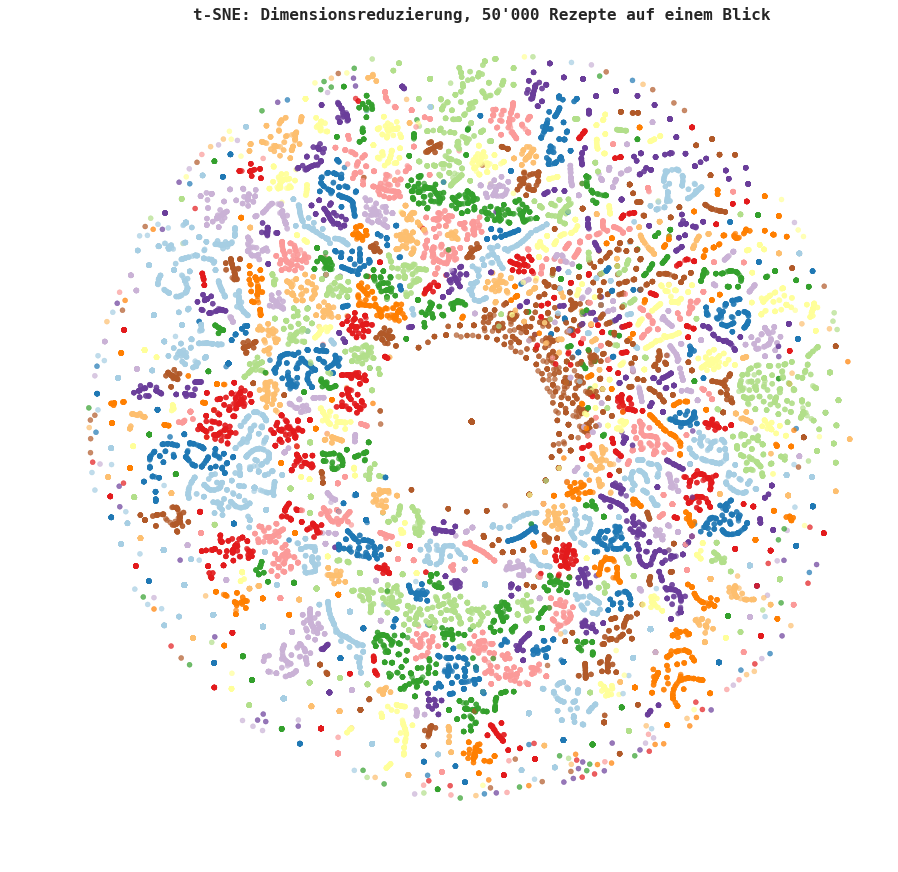

In [165]:
matplotlib.rc('font',family='monospace')
plt.style.use('seaborn-poster')

fig, axs = plt.subplots(1,1, figsize=(15, 15), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=.001)

#data = tsne_embedding
scatter = plt.scatter(data=tsne_embedding,x='x',y='y',s=25, c=tsne_embedding['hue'], cmap="Paired", alpha=0.7)
plt.axis('off')
plt.annotate('t-SNE: Dimensionsreduzierung, 50\'000 Rezepte auf einem Blick', xy=(0.17, 1), xycoords='axes fraction',
            fontsize = 16, weight = 'bold', alpha = .85)

plt.show()

In [166]:
legend_list = []
colors = []
for i in range(len(topics_category_300)):
    idx = np.where(tsne_embedding['hue']==i)[0][0]
    color = scatter.get_facecolors()[idx]
    colors.append(color)
    legend_list.append(mpatches.Ellipse((0, 0), 1, 1, fc=color))

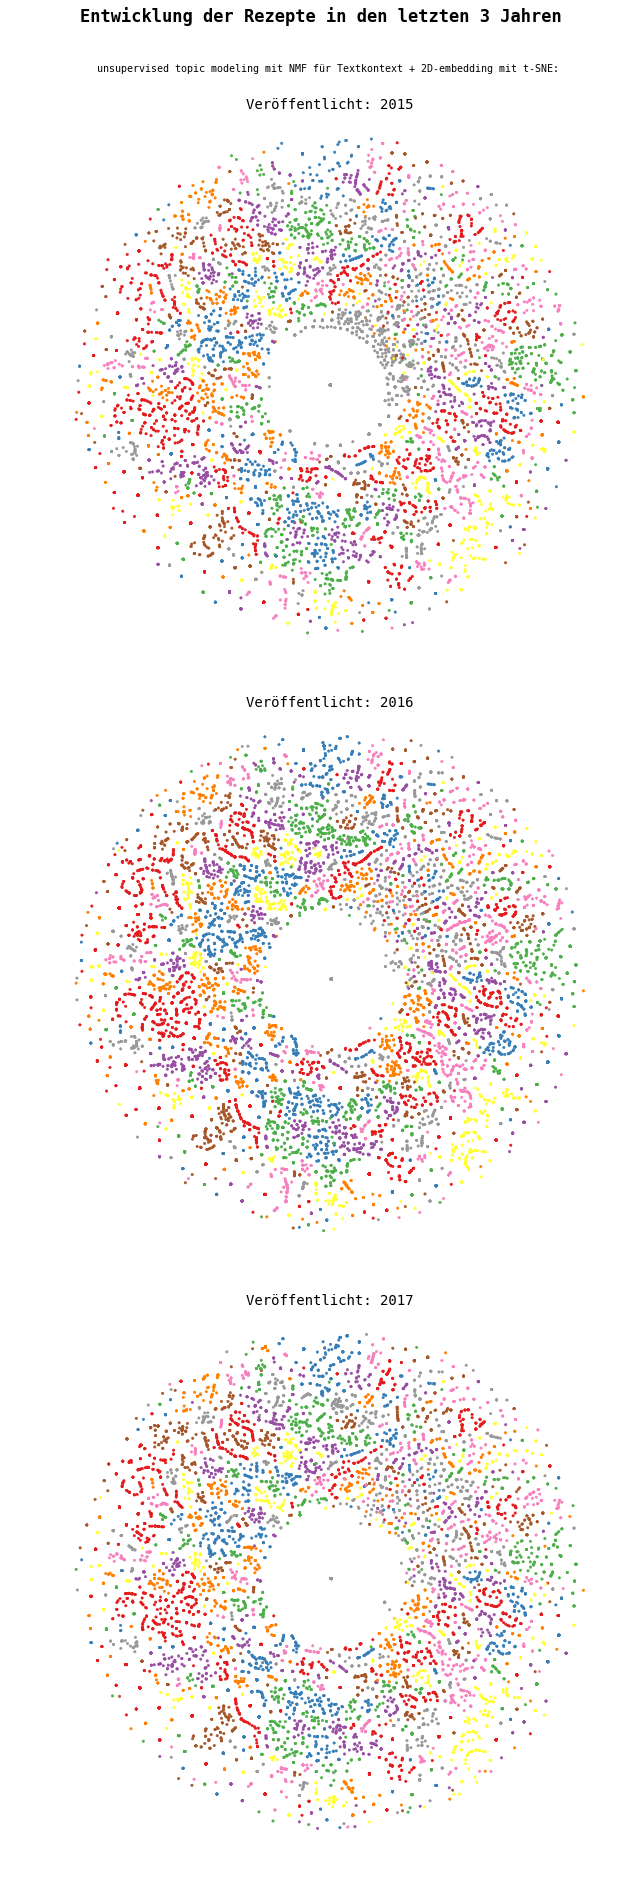

In [175]:
plt.style.use('ggplot')


fig, axs = plt.subplots(3,1, figsize=(10, 30), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=0.1)

axs = axs.ravel()

sorted_dataframe = rezepte_csv_analysis.sort_values(by='year', ascending=True)[266755:]
sorted_dataframe = sorted_dataframe.reset_index(drop=True)
count = 0
legend = []
for year, idx in zip([2015,2016,2017], range(3)):
    if year == 2015: data = tsne_embedding[sorted_dataframe['year']==year]
    elif year == 2016: data = tsne_embedding[sorted_dataframe['year']==year]
    elif year == 2017: data = tsne_embedding[sorted_dataframe['year']==year]
    scatter = axs[idx].scatter(data=data,x='x',y='y',s=6,c=data['hue'],cmap="Set1")
    axs[idx].set_title('Veröffentlicht: {}'.format(year),**{'fontsize':'14'})
    axs[idx].axis('off')

plt.suptitle("Entwicklung der Rezepte in den letzten 3 Jahren",**{'fontsize':'17','weight':'bold'})
plt.figtext(.51,0.95,'unsupervised topic modeling mit NMF für Textkontext + 2D-embedding mit t-SNE:', **{'fontsize':'10','weight':'light'}, ha='center')


#fig.legend(legend_list[:20],topics_category_300[:20],loc=(0.1,0.89))
plt.subplots_adjust(top=0.93)
plt.savefig('tsne_50000_3_years.pdf', format='pdf')
plt.show()

# Bilder Umbennenung
### Da man nun für jedes Rezept die passende Kategorie hat, kann man nun einen Ordner pro Kategorie machen mit den richtigen Bildern im richtigen Verzeichnis

In [309]:
import os

def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

In [3]:
def movePic(src, dest):
    os.rename(src, dest)

In [14]:
directories_names = []

for directt in topics_category_300:
    d_name = directt.replace(' ', '_')
    directories_names.append(d_name)

for curr_dir_category in directories_names:
    createFolder('./input/images/images/' + curr_dir_category)

In [4]:
!ls input/images/search_images/ | head -10

recipe-100001040044233-1.jpg
recipe-100001040044233-10.jpg
recipe-100001040044233-11.jpg
recipe-100001040044233-12.jpg
recipe-100001040044233-13.jpg
recipe-100001040044233-14.jpg
recipe-100001040044233-15.jpg
recipe-100001040044233-16.jpg
recipe-100001040044233-17.jpg
recipe-100001040044233-18.jpg


In [7]:
import csv
def get_recipe_id_cat():
    recipe_names_id_ = []
    recipe_names_cat_ = []
    skip_first = True # col name
    chef_file = 'input/test/chefkoch_rezepte_analysis_with_category.csv'
    with open(chef_file, 'r') as f:
        chefkoch = csv.reader(f)
        for row in chefkoch:
            if skip_first:
                skip_first = False
                continue
            try:
                recipe_names_id_.append(row[1])
                recipe_names_cat_.append(row[6])
            except:
                print('ERROR')
                continue 
    return recipe_names_id_, recipe_names_cat_

In [8]:
get_recipe_id_cat_ID, get_recipe_id_cat_CAT = get_recipe_id_cat()

from itertools import zip_longest
def create_dict(keys, values):
    return dict(zip_longest(keys, values[:len(keys)]))

id_key_cat_value = create_dict(get_recipe_id_cat_ID, get_recipe_id_cat_CAT)

In [ ]:
id_key_cat_value

In [ ]:
#input/images/search_thumbnails/recipe-100001040044233-0.jpg
#input/images/search_thumbnails/recipe-1000011205319453-0.jpg
#input/images/search_thumbnails/recipe-1000021205319843-0.jpg
# ...
import os
THUMBNAIL_DIR = 'input/images/search_thumbnails/'
OLD_IMG_DIR = 'input/images/search_images/'
files_moved = 0
for filename in os.listdir(THUMBNAIL_DIR):
    #print(os.path.join(THUMBNAIL_DIR, filename))
    if filename.endswith(".jpg"):
        comp_id = filename.split('-')[1]
        cat_val = id_key_cat_value.get(comp_id, '_')
        if cat_val == '_': continue
        cat_val = cat_val.replace(' ', '_')
        new_image_dest = cat_val+'-'+str(comp_id)+'-'+ str(filename.split('-')[2])+'.jpg'
        movePic(THUMBNAIL_DIR+filename, 'input/images/images/'+cat_val+'/'+new_image_dest)
        files_moved+=1
        if files_moved%10000==0: print('+= 10000')

## Zu wie vielen Bildern konnte keine Kategorie berechnet werden?

In [20]:
print(len([name for name in os.listdir('input/images/images/no_cat/') if name.endswith(".jpg")]))

305115


## Wie viele Bilder hat man nun pro Kategorie?

In [19]:
ALL_IMGS_DIR = 'input/images/images/'

for directory_ in directories_names:
    print('{} -> '.format(directory_), end='')
    print(len([name for name in os.listdir(os.path.join(ALL_IMGS_DIR, directory_)) if name.endswith(".jpg")]), end='\n')

spaghetti -> 6259
salat -> 4822
nudeln -> 3744
muffins -> 8074
nudelsalat -> 2399
tomaten -> 1579
torte -> 10338
kuchen -> 6445
pasta -> 2674
hähnchen -> 2725
kartoffel -> 1755
error -> 2331
apfelkuchen -> 8848
schweinefilet -> 2539
paprika -> 2606
kartoffelsalat -> 2992
apfel -> 3394
lachs -> 2337
gemüse -> 1816
käsekuchen -> 4707
spargel -> 2778
zucchini -> 2962
curry -> 1455
nudelauflauf -> 2189
rote_bete -> 2152
schoko -> 3373
bananen -> 2412
suppe -> 1430
hähnchenbrust -> 1473
käse -> 1381
reis -> 1960
gnocchi -> 2549
erdbeer -> 2704
lasagne -> 2981
pfannkuchen -> 2698
pizza -> 3165
quark -> 2640
auflauf -> 1354
kürbis -> 1735
ricotta -> 783
bandnudeln -> 1113
tiramisu -> 2756
kartoffeln -> 1862
dip -> 817
kartoffelsuppe -> 1491
feldsalat -> 1313
eier -> 2012
sauce -> 1561
tortellini -> 1411
joghurt -> 1858
champignons -> 1042
schnitzel -> 2484
penne -> 1125
kürbissuppe -> 941
bohnen -> 1183
smoothie -> 1554
creme -> 1591
brot -> 5326
spinat -> 1721
chili -> 1438
kirsch -> 3808
ta

# Nun hat man alle nötigen Datensätze für das Convolutional Neural Network (5. Teil)